In [1]:
import pandas_datareader as pdr
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import scipy.optimize as spop


In [4]:
# running thru a csv at the moment, yahoo finance is having trouble w/ their API, unable to grab data thru that medium
import os
window = 252 # number of trading days within a calendar year
t_threshold = -2.5 #our threshold test statistic
stocks = ['V', 'MA']
os.chdir("/Users/mishaelroy/Downloads/")
os.getcwd()
prices = pd.DataFrame()
for stock in stocks:
    data = pd.read_csv(stock + ".csv")
    prices[stock] = data['Close']
    returns[stock] = np.append((prices[stock][1:].reset_index(drop=True)/prices[stock][:-1].reset_index(drop=True) - 1), 0)


In [6]:
def check_for_cointegration(timeseries1, timeseries2, alpha=0.05):
    p_val = coint(timeseries1, timeseries2)[1]
    test_statistic = coint(timeseries1, timeseries2)[0]
    
    if p_val >= alpha:
        print("The series are NOT cointegrated")
        print("Test Statistic:", test_statistic)
        print("P-val:", str(p_val))
    else:
        print("The series ARE cointegrated")
        print("Test Statistic:", test_statistic)
        print("P-val:", str(p_val))

# this result tells us that there is a linear combination of the two stock prices (stock2 = a + b*stock1) such that
# the differences between our linear combination (fair_value) and the actual value are stationary
check_for_cointegration(prices['V'], prices['MA']) 

The series ARE cointegrated
Test Statistic: -3.943926070053201
P-val: 0.00861850466777542


In [5]:
# initializing arrays
gross_returns = np.array([])
test_statistics = np.array([])
stock1 = stocks[0] # Visa
stock2 = stocks[1] # Mastercard

In [7]:
cumulative_return = 0
cumulative_array = []
for i in range(window, len(data)):
    

    def unit_root(hedge):
        # a is the average difference between stock2 price and stock1price * hedge (a = AVG(stock2 - hedge*stock1)) 
        a = np.average(prices[stock2][i-window: i] - hedge*(prices[stock1][i-window:i]))
        
        #fair_value of stock 2 = a + hedge*stock1
        fair_value = a + hedge*prices[stock1][i-window:i] # computing fair value for stock 2 based on stock 1
        
        diff = np.array(fair_value - prices[stock2][i-window:i]) #difference between stock2 fair value and stock2 real value
        diff_variation = diff[1:] - diff[:-1] # computing dynamics of difference, we want it to converge to 0 in long run
        regression = sm.OLS(diff_variation, diff[:-1]).fit() # regression predicting dynamic difference based on lagged difference (differnece between ast and 2nd element based on 1st element)
        result = regression.params[0]/regression.bse[0]
        return result
        # computation of the Dicky-Fuller test statistic; testing for stationarity 

    #
    reg_1 = spop.minimize(unit_root, prices[stock2][i]/prices[stock1][i], method = "Nelder-Mead")
    optimal_t = reg_1.fun
    optimal_b = float(reg_1.x)
    optimal_a = np.average(prices[stock2][i-window:i] - optimal_b*prices[stock1][i-window:i])
    optimal_fair_value = optimal_a + optimal_b*prices[stock1][i]
    
    
    if i == window: # first instance of the loop
        old_signal = 0
    
    if optimal_t > t_threshold: # we don't trade
        signal = 0
        gross_return = 0
        
    else:
        # difference between perfect fair value and stock price as 1.0 for positive, -1.0 for negative
        signal = np.sign(optimal_fair_value - prices[stock2][i])
        gross_return = signal*returns[stock2][i] - signal*returns[stock1][i]
    
    gross_returns = np.append(gross_returns, gross_return)
    test_statistics = np.append(test_statistics, optimal_t)
    
    
    
    # day-to-day trading interface w/ applicable statistics
    print("day " + str(data.index[i]))
    print("")
    if signal == 0:
        print("no trading")
        
    elif signal == 1:
        print("long position on " + stock2 + ", short position on " + stock1)
    
    else:
        print("long position on " + stock1 + ", short position on " + stock2)
    cumulative_return += round(gross_return * 100, 2)
    cumulative_array = np.append(cumulative_array, cumulative_return)
    print("daily return: " + str(round(gross_return * 100, 2)) + "%")
    print("cumulative return: " + str(round(cumulative_return, 2)) + "%")
    print("")
    old_signal = signal


day 252

long position on V, short position on MA
daily return: 0.93%
cumulative return: 0.93%

day 253

long position on MA, short position on V
daily return: 0.2%
cumulative return: 1.13%

day 254

long position on MA, short position on V
daily return: 0.22%
cumulative return: 1.35%

day 255

long position on MA, short position on V
daily return: 0.87%
cumulative return: 2.22%

day 256

long position on V, short position on MA
daily return: -0.56%
cumulative return: 1.66%

day 257

long position on V, short position on MA
daily return: -0.27%
cumulative return: 1.39%

day 258

long position on V, short position on MA
daily return: -0.47%
cumulative return: 0.92%

day 259

long position on V, short position on MA
daily return: -5.37%
cumulative return: -4.45%

day 260

long position on V, short position on MA
daily return: 2.56%
cumulative return: -1.89%

day 261

long position on V, short position on MA
daily return: 0.43%
cumulative return: -1.46%

day 262

long position on V, short

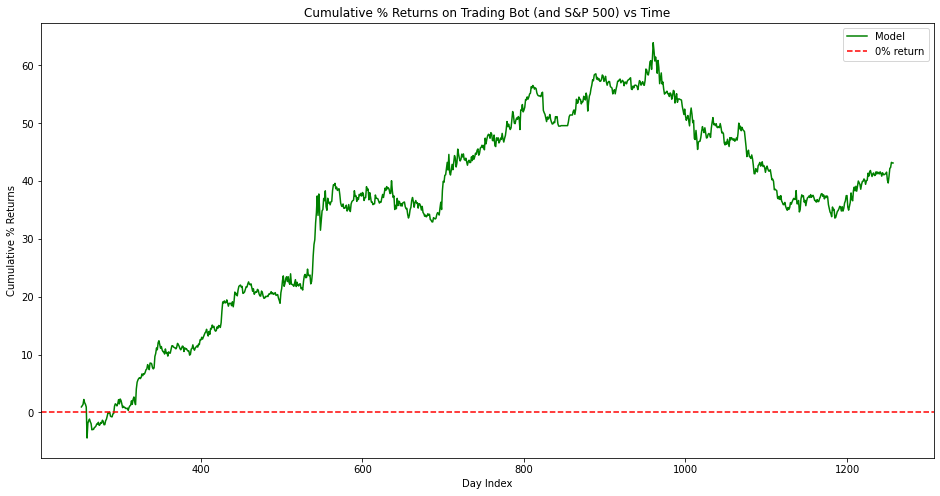

In [8]:
#sp = pdr.get_data_yahoo('^GSPC')['Close'] # importation of S&P 500 data sets 
#sp_ret = np.append(sp[1:].reset_index(drop=True)/sp[:-1].reset_index(drop=True) -1 , 0) #grabbing s&p returns over same time period

cumulative_array = pd.DataFrame(cumulative_array)
cumulative_array['days_index'] = range(window, len(data))
cumulative_array.set_index('days_index', inplace=True) # adjusting indexes for proper plot visual

plt.figure(figsize= (16,8))   
#plt.plot(sp_ret.cumsum()*100, color = "blue", label = "S&P")

plt.plot(cumulative_array, color = 'green', label = "Model")

plt.xlabel("Day Index")

plt.axhline(y = 0, color = "red", label = "0% return", ls = "--")

plt.title("Cumulative % Returns on Trading Bot (and S&P 500) vs Time")

plt.legend()

plt.ylabel("Cumulative % Returns")

plt.show()